In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os

In [ ]:
# Define relative file paths based on the directory structure
script_dir = os.path.dirname(os.path.abspath('ml-arcene'))  # Directory of visualization.ipynb (project/notebooks/)
root_dir = os.path.dirname(script_dir)  # Project root (project/)
data_dir = os.path.join(root_dir, 'data')  # project/data/
arcene_dir = os.path.join(data_dir, 'ARCENE')  # project/data/ARCENE/
img_dir = os.path.join(root_dir, 'images')  # project/images/

# File paths
train_data_path = os.path.join(arcene_dir, 'arcene_train.data')
train_labels_path = os.path.join(arcene_dir, 'arcene_train.labels')
valid_data_path = os.path.join(arcene_dir, 'arcene_valid.data')
valid_labels_path = os.path.join(data_dir, 'arcene_valid.labels')
test_data_path = os.path.join(arcene_dir, 'arcene_test.data')

In [10]:
# Load training data and labels
X_train = pd.read_csv(train_data_path, sep='\s+', header=None).values
y_train = pd.read_csv(train_labels_path, sep='\s+', header=None).values.ravel()

# Load validation data and labels
X_valid = pd.read_csv(valid_data_path, sep='\s+', header=None).values
y_valid = pd.read_csv(valid_labels_path, sep='\s+', header=None).values.ravel()

In [11]:
# Combine training and validation for visualization
X = np.vstack((X_train, X_valid))
y = np.hstack((y_train, y_valid))

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

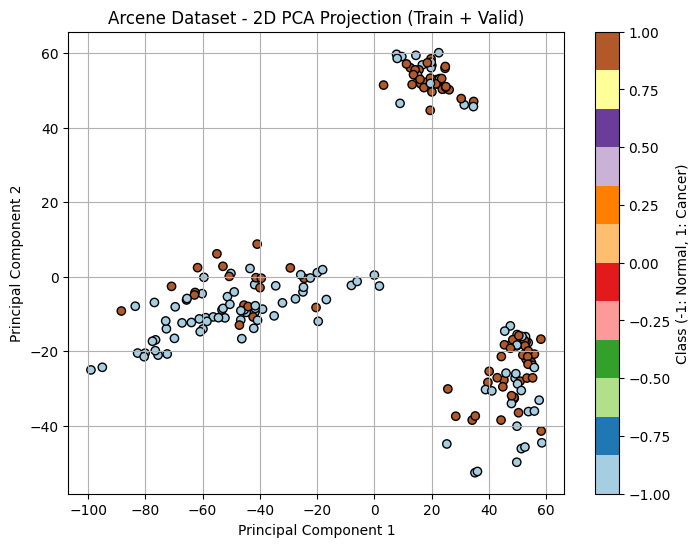

In [14]:
# Visualization 1: 2D PCA Projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='Paired', edgecolor='k')
plt.colorbar(scatter, label='Class (-1: Normal, 1: Cancer)')
plt.title('Arcene Dataset - 2D PCA Projection (Train + Valid)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.savefig(os.path.join(img_dir, 'arcene_pca_plot.png'))
plt.show()

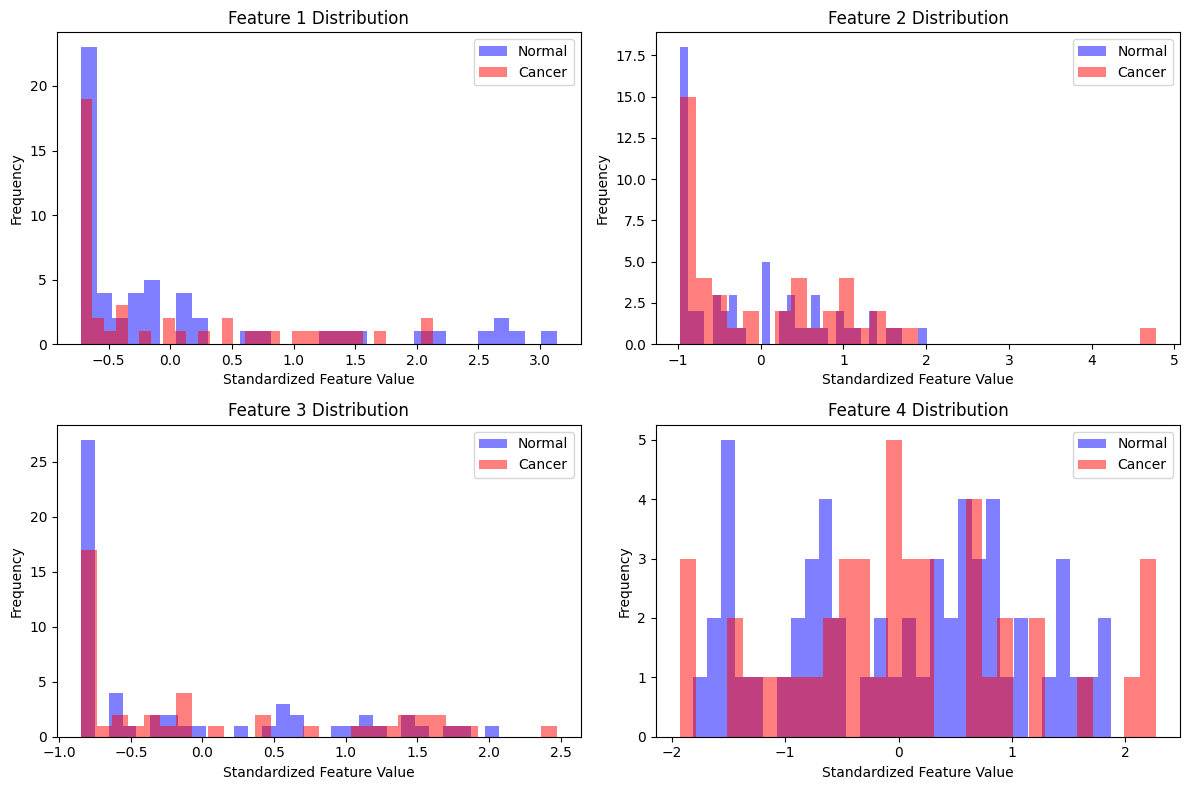

In [19]:
# Visualization 2: Histograms of First Few Features (Training Set)
X_train_scaled = scaler.transform(X_train)
plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.hist(X_train_scaled[y_train == -1, i], bins=30, alpha=0.5, label='Normal', color='blue')
    plt.hist(X_train_scaled[y_train == 1, i], bins=30, alpha=0.5, label='Cancer', color='red')
    plt.title(f'Feature {i+1} Distribution')
    plt.xlabel('Standardized Feature Value')
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'arcene_feature_histograms.png'))
plt.show()

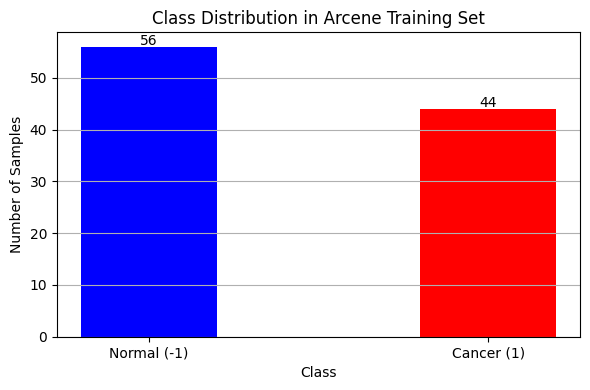

In [26]:
# Visualization 3: Class Distribution (Training Set)

plt.figure(figsize=(6, 4))
unique, counts = np.unique(y_train, return_counts=True)
bars = plt.bar(unique, counts, tick_label=['Normal (-1)', 'Cancer (1)'], color=['blue', 'red'])

# Add count labels on top of each bar
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height - 0.2, str(count), ha='center', va='bottom', fontsize=10)

plt.title('Class Distribution in Arcene Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'arcene_class_distribution.png'))
plt.show()
